In [17]:
# Check for CUDA availability and set the device
import torch
import os

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print device information
print(f"Using device: {device}")
if is_cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    # Set CUDA device visibility if needed
    # os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using device: cuda
CUDA Device: NVIDIA GeForce RTX 4070
CUDA Version: 12.8


In [18]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [19]:
# Define the transform_labels function to handle batched input
def transform_labels(examples):
	label_map = {"negative": 0, "neutral": 1, "positive": 2}
	if isinstance(examples['sentiment'], list):
		examples['labels'] = [label_map[s.lower()] for s in examples['sentiment']]
	else:
		examples['labels'] = label_map[examples['sentiment'].lower()]
	return examples

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")
model = AutoModelForSequenceClassification.from_pretrained("nojedag/xlm-roberta-finetuned-financial-news-sentiment-analysis-european")

# Move model to the appropriate device (GPU if available)
model = model.to(device)
print(f"Model moved to {device}")

Model moved to cuda


In [20]:
from datasets import load_dataset
synthetic_ds = load_dataset("nojedag/synthetic_financial_sentiment")
synthetic_ds = synthetic_ds.map(transform_labels, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

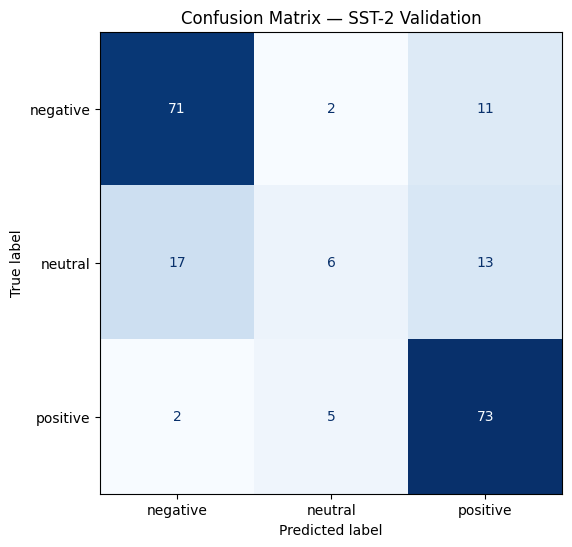

In [21]:
import numpy as np
from transformers import Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": (preds == labels).mean(),
    }

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        per_device_eval_batch_size=32,
        output_dir="./results",
        do_eval=True,
        no_cuda=not is_cuda_available,  # Use CUDA if available
    ),
    compute_metrics=compute_metrics,
)

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

# Apply tokenization to the dataset
tokenized_synthetic_ds = synthetic_ds.map(tokenize_function, batched=True)

# 5. Run evaluation to get raw preds & labels
eval_output = trainer.predict(tokenized_synthetic_ds["train"])
logits = eval_output.predictions  # shape (N_examples, N_labels)
labels = eval_output.label_ids     # shape (N_examples,)

# 6. Derive class predictions
preds = np.argmax(logits, axis=1)

# 7. Compute confusion matrix
cm = confusion_matrix(labels, preds)
# If you want normalized counts, pass `normalize='true'` or `normalize='pred'` etc.

# 8. Plot it
display_labels = ["negative", "neutral", "positive"]  # Based on label_map in transform_labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=display_labels
)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — SST-2 Validation")
plt.show()